<a href="https://colab.research.google.com/github/AamirKhaan/Student-Academic-Performance/blob/master/13_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color:Aqua; padding:20px; border-radius:10px">RandomForest</h1>

## Overview      

<div style="background-color:Gainsboro; padding:20px; text-align:justify; font-weight: bold">
    <p>In this section following steps are performed: </p>
    <ol>
        <li>Data Preparation and Encoding</li>
        <li>Preliminary RandomForest</li>
        <li>RandomForest Optimization with Minimal Cost Complexity Pruning</li>
        <li>RandomForest with optimized with optimized Cost Complexity Pruning</li>
        <li>Repeated Stratified k-Fold Cross Validation</li>
        <li>Model Learning Curve</li>
    </ol>
</div>


### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
# Jupyter Noteboook Configurations (personal prefrences)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set() 

In [3]:
# Global parameters for figure
plt.rcParams["figure.figsize"] = [10.00, 8.00]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.autolayout"] = True

### 1. Data Preparation and Encoding

#### 1.1 Import Modified Data

In [4]:
# Import the Student's data from local storage
# ! Dont' run the cell in colab
data_df = pd.read_csv('./data/xAPI-Edu-Data_modified.csv')

In [5]:
# Import the Student's data from github storage
# Run only in colab
url = 'https://raw.githubusercontent.com/AamirKhaan/Student-Academic-Performance/main/data/xAPI-Edu-Data_modified.csv'
data_df = pd.read_csv(url)

In [6]:
# Selected Features
CATEGORICAL_FEATURES = ['stage_id','relation', 'parent_answering_survey', 
                            'parent_school_satisfaction','student_absence_days']
NUMERICAL_FEATURES = ['raised_hands', 'visited_resources', 'announcements_view', 'discussion']
TARGET = ['class']

In [7]:
# Optimize Data Type for efficent memory utilization
for feature in CATEGORICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('category')
    
for feature in NUMERICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('int8')

data_df[TARGET] = data_df[TARGET].astype('category')

#### 1.2 Encode Data

In [8]:
# Input Features Encoding
categorical_encoder = OrdinalEncoder(dtype='int8')
categorical_ds  = categorical_encoder.fit_transform(data_df[CATEGORICAL_FEATURES])
categorical_encoded = pd.DataFrame(categorical_ds, columns=CATEGORICAL_FEATURES, dtype='int8')
# Target Encoding
target_encoder = LabelEncoder()
target_ds = target_encoder.fit_transform(data_df[TARGET])
target_encoded = pd.DataFrame(target_ds, columns=TARGET, dtype='int8')
# Combine the Data
encoded_df = pd.concat([categorical_encoded,data_df[NUMERICAL_FEATURES]], axis=1)

### 2.  Preliminary RandomForest Classifier

In [9]:
X = encoded_df
y = target_encoded

In [10]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# RandomForest Classifier
clf = RandomForestClassifier(random_state=42)

#### 2.1 Model Parameters

In [12]:
# Model parameters
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Train the model
clf = clf.fit(X_train, y_train)

#### 2.3 Model Scores

In [14]:
# Test Accuracy
y_hat = clf.predict(X_test)
initial_test_accuracy = accuracy_score(y_test, y_hat)
print(f'Preliminary RandomForest Test Accuracy: {initial_test_accuracy*100}')
# Train Accuracy
predictions_train = clf.predict(X_train)
initial_train_accuracy = accuracy_score(y_train, predictions_train)
print(f'Preliminary RandomForest Train Accuracy: {initial_train_accuracy*100}')

Preliminary RandomForest Test Accuracy: 79.74683544303798
Preliminary RandomForest Train Accuracy: 100.0


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the model on Training Data (100%) and the accuracy on Test Data (79.75%).</p>
</div>

#### 2.4 Confusion Matrix

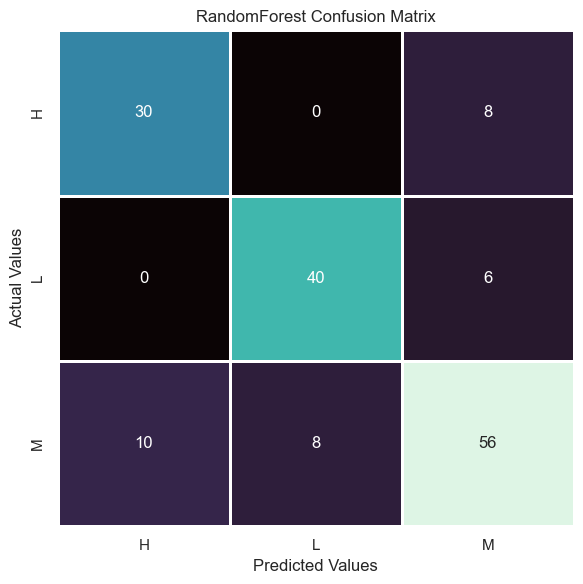

In [15]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_hat),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('RandomForest Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 2.5 Classification Report

In [16]:
print('RandomForest Classification Report\n')
print(classification_report(y_test,y_hat, target_names=['H','L','M']))

RandomForest Classification Report

              precision    recall  f1-score   support

           H       0.75      0.79      0.77        38
           L       0.83      0.87      0.85        46
           M       0.80      0.76      0.78        74

    accuracy                           0.80       158
   macro avg       0.79      0.81      0.80       158
weighted avg       0.80      0.80      0.80       158



### 3. RandomForest Classifier Optimization with Minimal Cost Complexity Pruning

In [17]:
# Taken from the base DT model.
ccp_alphas = [0.00267857, 0.00273437, 0.00286458,
       0.00288462, 0.00294118, 0.00297325, 0.00301535, 0.003125  ,
       0.003125  , 0.003125  , 0.003125  , 0.00340909, 0.0036655 ,
       0.00385417, 0.00416667, 0.00429036, 0.0046875 , 0.00474314,
       0.00476678, 0.005]

In [18]:
clf_rf = []
for n in ccp_alphas:
    clf = RandomForestClassifier(random_state=42,ccp_alpha = n)
    clf.fit(X_train, y_train)
    clf_rf.append(clf)

train_scores = [clf.score(X_train,y_train) for clf in clf_rf]
test_scores = [clf.score(X_test,y_test) for clf in clf_rf]

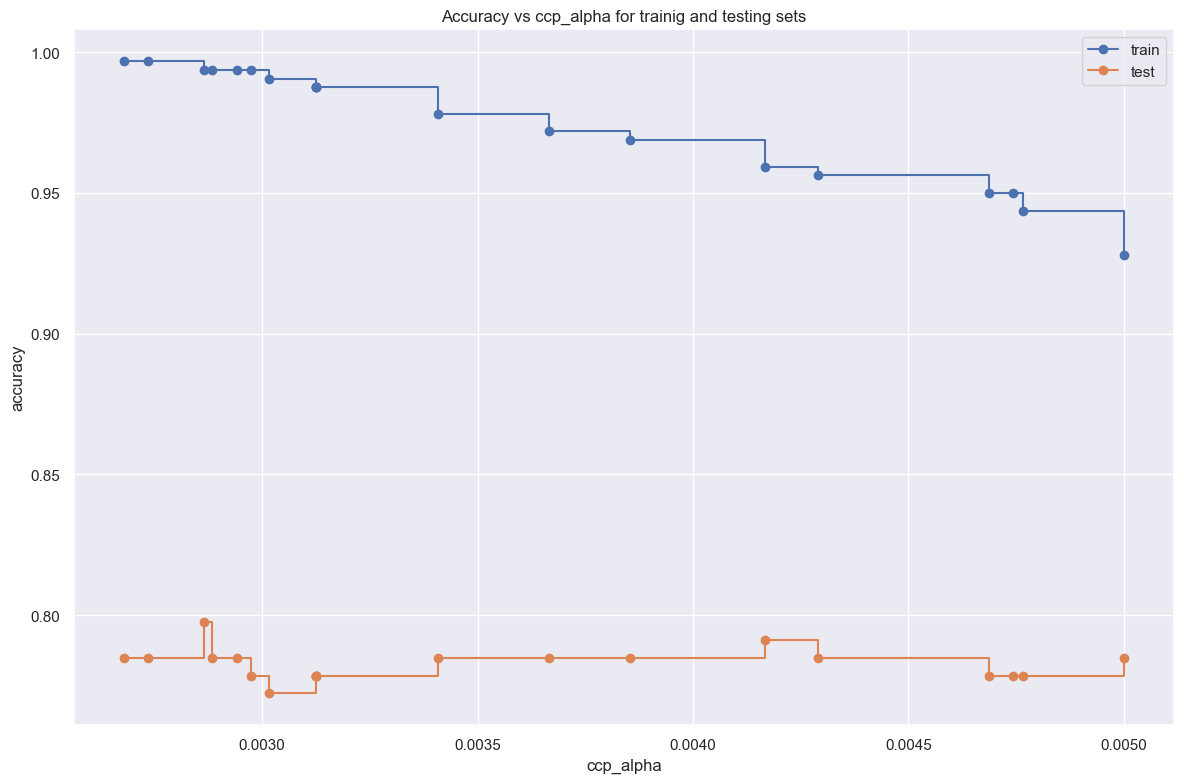

In [19]:
plt.rcParams["figure.figsize"] = [12.00, 8.00]
fig, ax = plt.subplots()
ax.set_xlabel('ccp_alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs ccp_alpha for trainig and testing sets')
ax.plot(ccp_alphas , train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas , test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

<div style="background-color:Gainsboro; padding:20px; text-align:justify;">
<p>The graph of accuracy vs ccp_alpha show the variation in the accuracy with respect to ccp_alpha values in Training and Test data. The peak accuracy is around ccp_alpha value of 0.00286458.</p>
</div>

In [20]:
# Get the index of the peak accuracy on the test data
index_max = test_scores.index(max(test_scores))

### 4. RandomForest with optimized Minimal Cost Complexity Pruning

#### 4.1 Optimized RandomForest Parameters

In [21]:
clf_rf[index_max].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.00286458,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### 4.2 Optimized RandomForest Scores

In [22]:
# Test Accuracy
opt_y_test = clf_rf[index_max].predict(X_test)
opt_test_accuracy = accuracy_score(y_test, opt_y_test)
print(f'Optimized RandomForest Test Accuracy: {opt_test_accuracy*100}')
# Train Accuracy
opt_y_train = clf_rf[index_max].predict(X_train)
opt_train_accuracy = accuracy_score(y_train, opt_y_train)
print(f'Optimized RandomForest Train Accuracy: {opt_train_accuracy*100}')

Optimized RandomForest Test Accuracy: 79.74683544303798
Optimized RandomForest Train Accuracy: 99.375


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the optimized model on Training Data (99.37%) greater than the accuracy on Test Data (79.746%). The model shows acceptable performance. </p>
</div>

#### 4.3 Optimized RandomForest Confusion Matrix

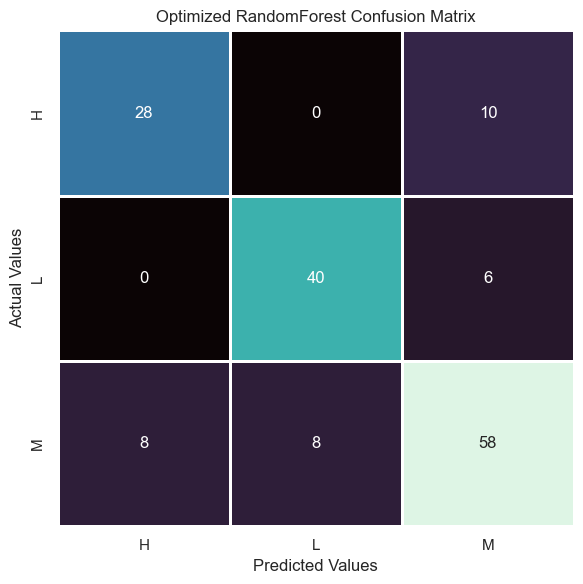

In [23]:
ocm_df = pd.DataFrame(confusion_matrix(y_test, opt_y_test),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(ocm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Optimized RandomForest Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 4.4 Optimized RandomForest Classification report

In [24]:
print('Optimized RandomForest Classifier Report\n')
print(classification_report(y_test,opt_y_test, target_names=['H','L','M']))

Optimized RandomForest Classifier Report

              precision    recall  f1-score   support

           H       0.78      0.74      0.76        38
           L       0.83      0.87      0.85        46
           M       0.78      0.78      0.78        74

    accuracy                           0.80       158
   macro avg       0.80      0.80      0.80       158
weighted avg       0.80      0.80      0.80       158



### 5. Repeated Stratified k-Fold Cross Validation

In [25]:
# Model
clf_cv = RandomForestClassifier(random_state=42,ccp_alpha = 0.00286458)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(clf_cv, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1)

# Performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.760 (0.054)


### 6. Model Learning Curve

In [26]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(random_state=42,ccp_alpha = 0.00286458)

train_sizes=np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        return_times=True,
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

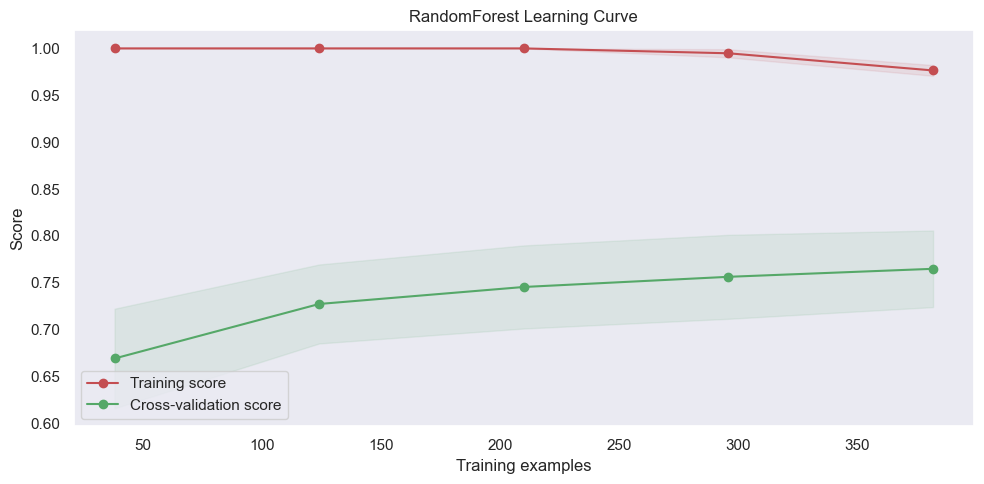

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('RandomForest Learning Curve')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
# Plot learning curve
ax.grid()
ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",)

ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",)
    
ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")   
ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")   
ax.legend(loc="best");

## Observations
  
The key observations are:  
     
1. The Initial RandomForest has:     
    a. Test Accuracy of 79.75%     
    b. Train Accuracy of 100%     
2. Minimal Cost Complexity Pruning at ccp_alph of approximately 0.00286458 results in highest accuracy of 79.75%.
3. The Optimized RandomForest has:   
    a. Test Accuracy of 79.75%     
    b. Train Accuracy of 99.38%    
4. The 10 Fold Cross Validation for the RandomForest in Mean Accuracy of 76%.

## Conclusion
Based on the obervations:

1. The RandomForest with Minimal Cost Complexity Prunning produced the maximum test accuracy of 79.75%.
2. The Cross Validation produced mean accuracy of76 % that show the model quite well trained and generalized over the given data. 